# _Machine Learning Project: "Classification of EMG Signals"_
## Introduction: EMG Data Analysis
This notebook is based on the EMG data analysis - a study conducted by the UC of Irvine in California. It presents an analysis of EMG data using machine learning models. The goal is to classify physical actions based on EMG signals.

Electromyography (EMG) measures muscle response or electrical activity in response to a nerve's stimulation of the muscle. The test is used to help detect neuromuscular abnormalities. During the test, one or more small needles (also called electrodes) are inserted through the skin into the muscle.

Possible Use cases for this type of analysis can be- medical diagnosis or build a human-robot interface.

Dataset: https://archive.ics.uci.edu/ml/datasets/EMG+Physical+Action+Data+Set

Derived from the work by:

Theo Theodoridis\
School of Computer Science and Electronic Engineering\
University of Essex

Prepared by:

Bernard Maacaron\
Anna Hauschild\
EMARO - European Master on Advanced Robotics\
University of Genova - Grande Ecole Centrale de Nantes



## Understanding the Dataset
Bio Electrical Signals collected from a group of 4 subjects who were asked to perform specific physical activities. The dataset contains 8 columns, each corresponding to a different electrode location on the body.
**The dataset is divided into two categories:**
1. Normal activities
2. Aggressive activities

The normal activities include standing, sitting, and hugging, while the aggressive activities include kicking, punching, and hammering.

- R-Bic: right bicep (C1)
- R-Tri: right tricep (C2)
- L-Bic: left bicep (C3)
- L-Tri: left tricep (C4)
- R-Thi: right thigh (C5)
- R-Ham: right hamstring (C6)
- L-Thi: left thigh (C7)
- L-Ham: left hamstring (C8)

Each file in the dataset contains overall 8 columns.

- Measurment frequency: $10^4\ \text{samples per second.}$

### Neurobiology and Machine Learning for Activity Prediction

In neurobiology, it has been observed that the same neural signals are activated when imagining an activity, such as jumping, as when physically performing the activity. This phenomenon presents a unique opportunity to leverage machine learning (ML) models for predicting physical activities based on neural signals. Such models have potential applications in controlling robotic movements and aiding in various diagnostic and monitoring tasks.

For each activity, neural signals are recorded from the onset to the completion of the activity. This results in approximately 10,000 rows of data for a single activity, capturing the dynamic nature of neural activity throughout its performance.


## Data Loading and Preprocessing
The dataset is loaded and preprocessed to prepare it for model training.\
It is available in the form of text files, where each file corresponds to a different physical activity. The data is loaded into a pandas DataFrame and preprocessed to ensure that it is in the correct format for training machine learning models.

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
seed = 42 # Set seed for reproducibility
verb = 0 # Set verbosity level

data = pd.DataFrame()
Num_Subjects = 4
chunk_size = 200
data_path = os.path.join('emg+physical+action+data+set','EMG Physical Action Data Set')
actions_cat = ['Aggressive', 'Normal']
actions_cat = ['Normal']
aggregate = False
aggregate_by_muscle = False

# Merging the features of the dataframe
def merge_features(df, by_muscle=True):
    if by_muscle:
        df['bicep_emg'] = df[['ch1', 'ch2']].sum(axis=1)
        df['tricep_emg'] = df[['ch3', 'ch4']].sum(axis=1)
        df['hamstring_emg'] = df[['ch5', 'ch6']].sum(axis=1)
        df['quadricep_emg'] = df[['ch7', 'ch8']].sum(axis=1)
    else:
        df['arm_emg'] = df[['ch1', 'ch2', 'ch3', 'ch4']].sum(axis=1)
        df['leg_emg'] = df[['ch5', 'ch6', 'ch7', 'ch8']].sum(axis=1)
    
    df.drop(['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'], axis=1, inplace=True)
    return df

# Extracting the data from the files and storing it in a dataframe
def create_dataset(data, Num_Subjects, data_path, chunk_size=10, aggregate = False, aggregate_by_muscle = True):
    actions = {}  # Dictionary to store action names with numeric labels
    actions_by_category = {'Aggressive': [], 'Normal': []}  # Dictionary to store actions by category
    action_ind = 0
    for index in range(Num_Subjects):
        for action_type in actions_cat:
            print(f"Processing subject {index+1} {action_type} actions")
            input_path = os.path.join(data_path, f'sub{index+1}', action_type, 'txt')
        
            for files in os.listdir(input_path):
                subject_path =  os.path.join(input_path, files)
                df = pd.read_csv(subject_path,
                                 sep='\t',
                                 names = ["ch" + str(i) for i in range(1, 9)],
                                 header=None)
                
                if aggregate:
                    df = merge_features(df, by_muscle=aggregate_by_muscle)
                
                temp_chunked = pd.DataFrame()

                for j in range(0, len(df), chunk_size):
                    chunk_max = df.iloc[j:j+chunk_size].max()
                    temp_chunked = pd.concat([temp_chunked, pd.DataFrame(chunk_max).T], ignore_index=True)
            
                action_name = files[:-4]  # Extract action name from filename
                if action_name not in actions:
                    actions[action_name] = action_ind  # Assign a new numeric label if action is not in the dictionary
                    action_ind += 1
                temp_chunked["Action"] = [action_name]*len(temp_chunked)
                
                # Categorize the action
                if action_name not in actions_by_category[action_type]:
                    actions_by_category[action_type].append(action_name)

                data = pd.concat([data, temp_chunked], ignore_index=True)
    return actions, actions_by_category, data

actions, actions_by_category, data = create_dataset(data, Num_Subjects, data_path, chunk_size, aggregate, aggregate_by_muscle)

Processing subject 1 Normal actions
Processing subject 2 Normal actions
Processing subject 3 Normal actions
Processing subject 4 Normal actions


### Exploratory data analysis

The dataset is explored to understand its structure and characteristics. This includes checking the number of samples for each activity, visualizing the data, and identifying any potential issues that need to be addressed during preprocessing.

In [96]:
display(data.head(10))
print(data.shape)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Action
0,592.0,208.0,1835.0,205.0,320.0,71.0,4000.0,707.0,Clapping
1,1311.0,383.0,4000.0,329.0,403.0,86.0,942.0,927.0,Clapping
2,475.0,160.0,2396.0,67.0,335.0,73.0,4000.0,695.0,Clapping
3,880.0,387.0,3629.0,128.0,237.0,72.0,4000.0,817.0,Clapping
4,1572.0,484.0,3967.0,129.0,201.0,65.0,2687.0,673.0,Clapping
5,391.0,452.0,2602.0,111.0,214.0,70.0,4000.0,1125.0,Clapping
6,1867.0,725.0,2746.0,124.0,150.0,70.0,844.0,586.0,Clapping
7,315.0,159.0,1216.0,81.0,275.0,77.0,4000.0,652.0,Clapping
8,1038.0,1012.0,2852.0,142.0,302.0,64.0,872.0,656.0,Clapping
9,513.0,537.0,2005.0,114.0,328.0,77.0,4000.0,360.0,Clapping


(1997, 9)


In [97]:
# Exploratory Data Analysis
data.info()
display(data.describe())

# Chekcing for missing values
null_per_channel = data.isnull().sum()
percentages = (null_per_channel / len(data)) * 100
# Create a DataFrame with both counts and percentages, and specify column names
result_df = pd.DataFrame({
    'Num. of NaN': null_per_channel,
    'Percentage': percentages
})

print("Number of missing values in the data per chanel:")
display(result_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ch1     1997 non-null   float64
 1   ch2     1997 non-null   float64
 2   ch3     1997 non-null   float64
 3   ch4     1997 non-null   float64
 4   ch5     1997 non-null   float64
 5   ch6     1997 non-null   float64
 6   ch7     1997 non-null   float64
 7   ch8     1997 non-null   float64
 8   Action  1997 non-null   object 
dtypes: float64(8), object(1)
memory usage: 140.5+ KB


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
count,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000
mean,1285.541312,641.434652,1054.127191,624.030045,1506.212318,1218.685028,1258.590886,1283.275413
std,1328.836792,1031.375529,1390.108918,1063.982649,1675.144342,1541.482481,1620.383956,1501.792160
min,-17.000000,-13.000000,-13.000000,-20.000000,-20.000000,18.000000,19.000000,11.000000
25%,95.000000,87.000000,45.000000,42.000000,88.000000,82.000000,81.000000,87.000000
50%,798.000000,198.000000,163.000000,110.000000,416.000000,327.000000,172.000000,485.000000
75%,2158.000000,572.000000,1875.000000,598.000000,3988.000000,2359.000000,2843.000000,2437.000000
max,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000


Number of missing values in the data per chanel:


,Num. of NaN,Percentage
ch1,0,0.0
ch2,0,0.0
ch3,0,0.0
ch4,0,0.0
ch5,0,0.0
ch6,0,0.0
ch7,0,0.0
ch8,0,0.0
Action,0,0.0


In [98]:
# Removing missing values
data = data.dropna()
data.reset_index(drop=True, inplace=True)

# Checking for missing values after removing them
null_per_channel = data.isnull().sum()
percentages = (null_per_channel / len(data)) * 100
# Create a DataFrame with both counts and percentages, and specify column names
result_df = pd.DataFrame({
    'Num. of NaN': null_per_channel,
    'Percentage': percentages
})

print("Number of missing values in the data per chanel:")
display(result_df)

Number of missing values in the data per chanel:


,Num. of NaN,Percentage
ch1,0,0.0
ch2,0,0.0
ch3,0,0.0
ch4,0,0.0
ch5,0,0.0
ch6,0,0.0
ch7,0,0.0
ch8,0,0.0
Action,0,0.0


Unique labels:


,0,1,2,3,4,5,6,7,8,9
0,Bowing,Clapping,Handshaking,Hugging,Jumping,Running,Seating,Standing,Walking,Waving


Value counts and percentages of each action:


,Counts,Percentage
Action,,
Clapping,203,10.165248
Bowing,203,10.165248
Walking,201,10.065098
Waving,200,10.015023
Jumping,199,9.964947
Running,199,9.964947
Handshaking,198,9.914872
Standing,198,9.914872
Hugging,198,9.914872


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Clapping'),
  Text(1, 0, 'Bowing'),
  Text(2, 0, 'Walking'),
  Text(3, 0, 'Waving'),
  Text(4, 0, 'Jumping'),
  Text(5, 0, 'Running'),
  Text(6, 0, 'Handshaking'),
  Text(7, 0, 'Standing'),
  Text(8, 0, 'Hugging'),
  Text(9, 0, 'Seating')])

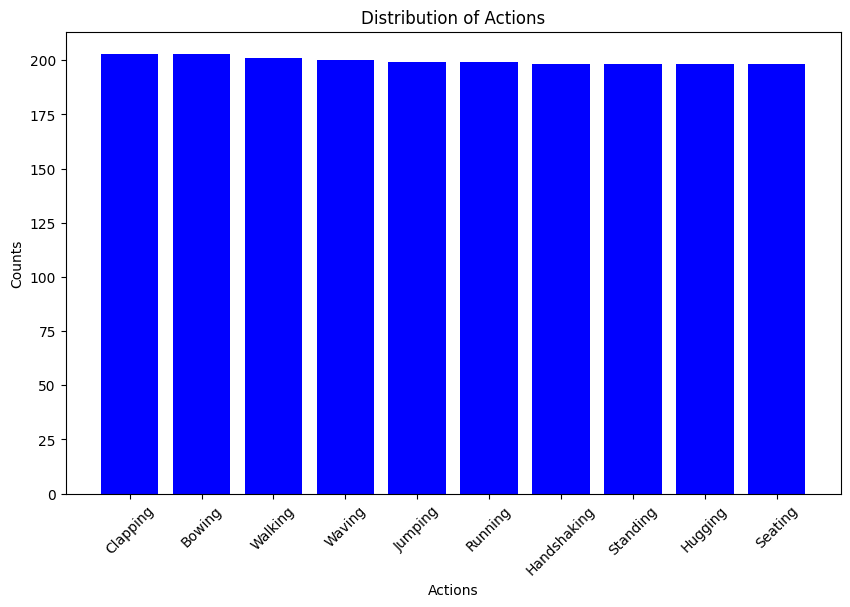

In [99]:
# Splitting the data into features and labels
X = data.drop('Action', axis=1)
y = data['Action']

print("Unique labels:")
display(pd.DataFrame(np.unique(y)).T) # Displaying the unique labels

# Encoding the target variable
# Encoding labels
y_encoded = y.map(actions)

# Checking the distribution of the actions
value_counts = y.value_counts()
percentages = (value_counts / len(y)) * 100
# Create a DataFrame with both counts and percentages, and specify column names
result_df = pd.DataFrame({
    'Counts': value_counts,
    'Percentage': percentages
})

print("Value counts and percentages of each action:")
display(result_df)

# Plotting the distribution of the actions
colors = ['red' if action in actions_by_category['Aggressive'] else 'blue' for action in result_df.index]

plt.figure(figsize=(10, 6))
plt.bar(result_df.index, result_df['Counts'], color=colors)  # Apply the colors list here
plt.title('Distribution of Actions')
plt.xlabel('Actions')
plt.ylabel('Counts')
plt.xticks(rotation=45)

NOTE: TO BE MODIFIED!!!!!!!!!!!!!!!!!!!!!\
The dataset does not have any missing values, as indicated by the output of data.isnull().sum(). Therefore, there is no need for data processing to handle missing values.

However, depending on the specific analysis or machine learning task, further data processing steps may be required. For example, if the goal is to train a machine learning model to classify the physical actions based on the EMG signals, additional preprocessing steps such as feature scaling or encoding categorical variables may be necessary. Similarly, if the goal is to analyze the relationship between the EMG signals and the physical actions, further exploratory data analysis and feature engineering may be needed. Overall, the specific data processing steps will depend on the goals of the analysis or machine learning task.

### Data Preprocessing

The data is preprocessed to ensure that it is in the correct format for training machine learning models. This includes normalizing the data, splitting it into training and testing sets, and encoding the target variable.

Additionally, we perform domain-specific feature engineering to extract relevant features from the raw data. This involves taking the rectified "spikes" of the EMG signals over a sliding window to capture the temporal dynamics of the neural activity.

In [100]:
# Normalizing the data
def normalize_data(x_train, x_test, x_val):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    x_val_scaled = scaler.transform(x_val)

    return x_train_scaled, x_test_scaled, x_val_scaled

#we perform domain-specific feature engineering to extract relevant features from the raw data. This involves taking the rectified maximum of the EMG signals over a window to capture the temporal dynamics of the neural activity.
# Domain Specified Feature Engineering
X = abs(X)

# Splitting the data into training and testing sets
# Shuffle is set to True by default, as such, the data will be shuffled before splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

## Model Exploration

### Decision Tree Classifier
We will start by training a Decision Tree Classifier on the dataset. The Decision Tree Classifier is a simple and interpretable model that can be used for classification tasks. This model will serve as a baseline for evaluating more complex models notably Random Forest and Support Vector Machines.

In [101]:
# We train a simple decision tree using 5-fold cross validation and Grid Search for best hyper-param selection
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": list(range(3, 21, 2)),  # You already have this
    "min_samples_split": [2, 5, 10, 20],  # Adding more options
    "min_samples_leaf": [1, 2, 5, 10],  # Adding more options
    "max_features": ["sqrt", "log2"],  # Considering all features vs a subset
    "max_leaf_nodes": list(range(2, 20, 2))  # Adding None as an option
}

modelDTC = DTC(random_state=seed)
clf = GridSearchCV(modelDTC, params, scoring = "balanced_accuracy", cv = 5, n_jobs=-1, verbose = verb)

clf.fit(X_val, y_val)

# Dipalying the grid search results in a dataframe - only the mean test score is displayed
results = pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)
display(results[[col for col in results.columns if col.startswith('param_')]])
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
print("Best estimator:", clf.best_estimator_)



,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split
2582,19,log2,18,2,10
2578,19,log2,18,1,10
1718,13,log2,18,2,10
1138,9,log2,18,1,10
1142,9,log2,18,2,10


Best parameters: {'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 18, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.6807380952380953
Best estimator: DecisionTreeClassifier(max_depth=9, max_features='log2', max_leaf_nodes=18,
                       min_samples_split=10, random_state=42)


In [102]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, X, Y, title):

  train_sizes, train_scores, test_scores, _, _ = learning_curve(estimator, X, Y, return_times=True, n_jobs=-1, cv=5,
                                                                random_state=seed, verbose = verb, error_score='raise', scoring='balanced_accuracy')

  fig, axes = plt.subplots(1, 1, figsize = (10, 5))

  axes.set_title(title)
  axes.plot
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")


  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  
  print(train_scores_mean)
  print(train_scores_std)
  print(test_scores_mean)
  print(test_scores_std)

  # Plot learning curve
  axes.grid()
  axes.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color="r",
  )
  axes.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",
  )
  axes.plot(
      train_sizes, train_scores_mean, "o-", color="r", label="Training score"
  )
  axes.plot(
      train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
  )
  axes.legend(loc="best")
  
def print_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Reds)
    fig.colorbar(cax)

    # Set grid lines based on the matrix size
    ax.set_xticks(np.arange(-.5, len(result_df.index), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(result_df.index), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(len(result_df.index)))
    ax.set_yticks(np.arange(len(result_df.index)))
    plt.xticks(rotation=45)

    # Labels, title and ticks
    ax.set_xticklabels(result_df.index)
    ax.set_yticklabels(result_df.index)
    plt.xlabel('Predictions', fontsize=16)
    plt.ylabel('Actuals', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), ha="center", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

def generateConfusionMatrix(y_test, predictions):
    # Generate and print the confusion matrix
    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the figure size as needed

    disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions,
                                               display_labels=actions.keys(), ax=ax, xticks_rotation=45)
    # Now, color the x and y tick labels based on their category
    for tick in ax.get_xticklabels():
        tick.set_color(assign_color(tick.get_text(), actions_by_category))
    for tick in ax.get_yticklabels():
        tick.set_color(assign_color(tick.get_text(), actions_by_category))            

# Define a function to assign colors based on the category
def assign_color(label, actions_by_category):
    for category, actions in actions_by_category.items():
        if label in actions:
            return 'red' if category == 'Aggressive' else 'blue'
    return 'black'  # Default color if not found

[0.8908851  0.77112465 0.74908535 0.72681123 0.70718803]
[0.03208262 0.0177463  0.02302837 0.0058423  0.00865183]
[0.57823969 0.65297329 0.6740867  0.66629256 0.65354142]
[0.02868377 0.02570819 0.03789163 0.01798262 0.0168696 ]
DTC Model score on train data: 0.6528274874731568


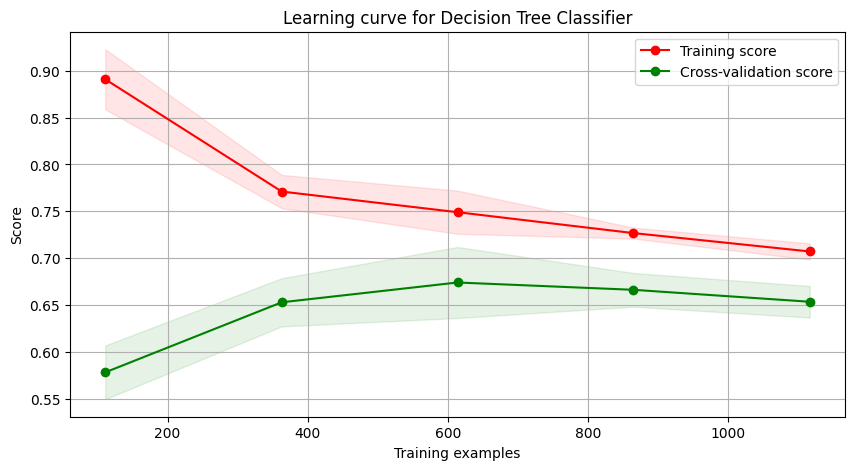

In [103]:
modelDTC = clf.best_estimator_
plot_learning_curve(modelDTC, X_train, y_train, "Learning curve for Decision Tree Classifier")
print("DTC Model score on train data:", modelDTC.score(X_train, y_train))

In [104]:
modelDTC.fit(X_train, y_train)
# Predictions
predictions = modelDTC.predict(X_test)
# Evaluate the model
accuracyDTC = balanced_accuracy_score(y_test, predictions)
print(f"Accuracy of the DTC model on Test Data: {accuracyDTC * 100:.2f}%")

Accuracy of the DTC model on Test Data: 62.76%


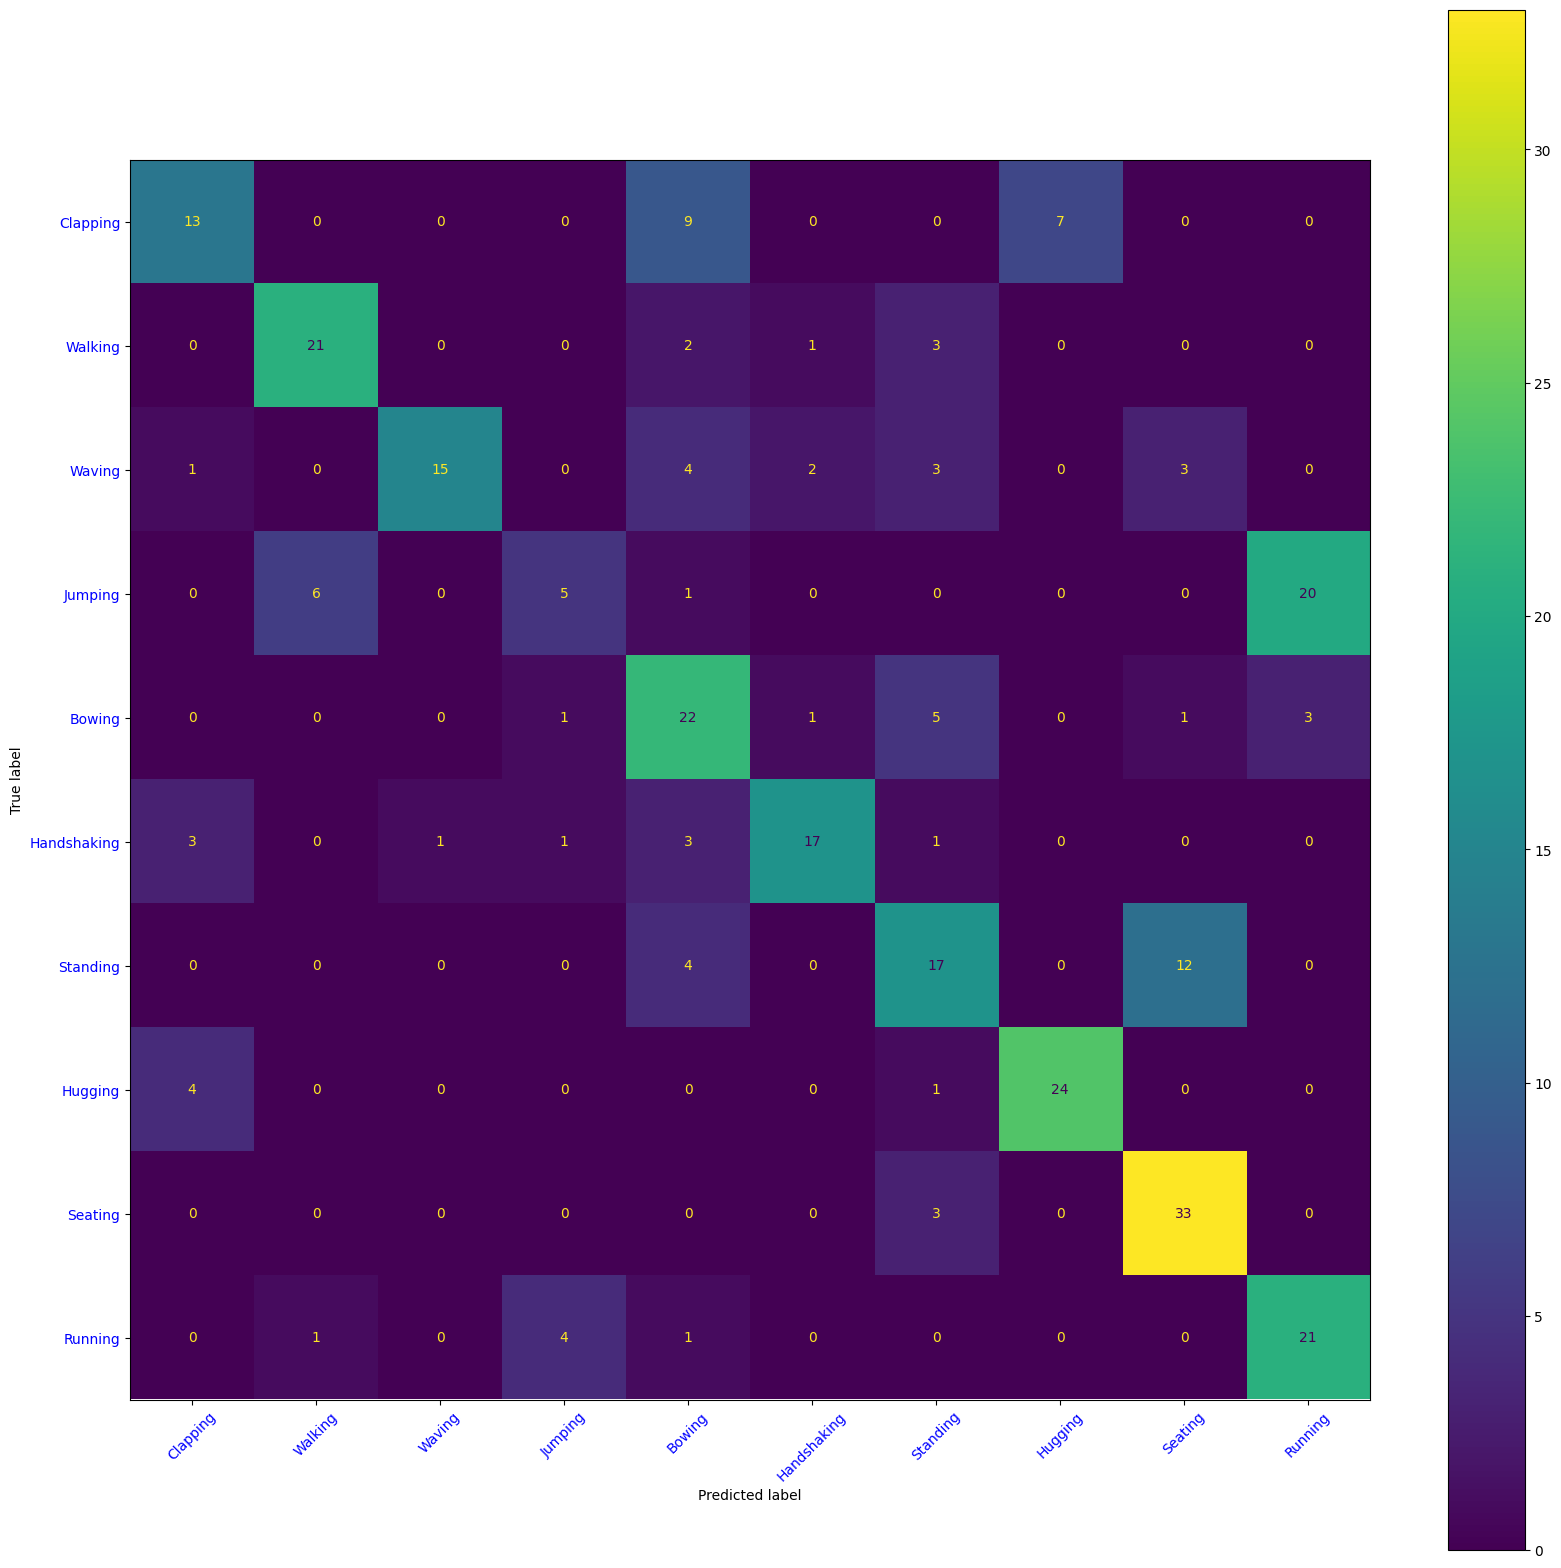

In [105]:
generateConfusionMatrix(y_test, predictions)

#### Interpretation of the Decision Tree Performance
The performance of the Decision Tree Classifier is evaluated using metrics such as accuracy, precision, recall, and F1 score. Each of these metrics provides a different perspective on the model's performance, especially in classification tasks:

- **Accuracy**:\
This metric measures the proportion of correctly predicted observations to the total observations. It's the most intuitive performance measure, indicating the overall correctness of the model's predictions.
$$\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Observations}} $$

- **Precision**:\
Precision measures the ratio of correctly predicted positive observations to the total predicted positive observations. It indicates the model's ability to return relevant results, minimizing false positives.
$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

- **Recall (Sensitivity or True Positive Rate)**:\
Recall measures the ratio of correctly predicted positive observations to all observations in the actual class. It reflects the model's ability to find all relevant cases within a dataset, minimizing false negatives.
$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

- **F1 Score**:\
The F1 Score is the harmonic mean of precision and recall, considering both false positives and false negatives. It's a balanced measure of the model's precision and recall, useful for comparing two classifiers.
$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

When the data size is small the model overfits and we see a big difference between the training score and cv score.
Overfitting occurs when the model learns the training data too well, including its noise and outliers, leading to poor performance on new, unseen data. As the number of training samples increases, the training and cross-validation scores tend to converge, suggesting that the model generalizes better to new data.


### Random Forest Model
In our approach to classifying physical actions based on EMG signals, we opted to start with Random Forest before proceeding to Support Vector Machines (SVMs). This decision was influenced by several considerations that align with the unique characteristics of our dataset and the strengths of Random Forest:

1. **Handling Non-linear Data:** Random Forest excels in capturing complex, non-linear relationships between features, a common scenario in EMG data where the interaction between muscle signals and physical actions is intricate. Starting with Random Forest allows us to immediately address this complexity.

2. **Feature Importance Insights:** A pivotal advantage of Random Forest is its ability to evaluate and rank the importance of features in the classification process. By using Random Forest first, we gain valuable insights into which electrodes (channels) or derived features are most predictive of physical actions, guiding our subsequent analysis and potentially simplifying the feature space for SVM.

3. **Robustness and Generalization:** Random Forest is known for its robustness to overfitting, thanks to its ensemble approach. This makes it an ideal starting point, ensuring that our initial model generalizes well to unseen data, providing a solid baseline for comparison with the more sensitive SVM.

4. **Ease of Implementation and Interpretability:** Despite its complexity, Random Forest is relatively straightforward to implement and tune. Its results are also easier to interpret compared to SVM, especially when it comes to understanding decision paths. Starting with Random Forest allows us to quickly deploy a model and interpret its outcomes before diving into the more nuanced SVM.

5. **Handling Imbalanced Data:** Given that EMG datasets can often be imbalanced, Random Forest's inherent ability to manage class imbalance effectively makes it a suitable first choice. This ensures that our initial model is sensitive to under-represented classes, a crucial consideration in achieving high overall accuracy.

6. **Setting a Performance Benchmark:** By deploying Random Forest first, we establish a performance benchmark based on its ability to handle non-linearity, feature importance, and class imbalance. This benchmark is invaluable when we later introduce SVM, as it helps us to directly assess the incremental value added by SVM's high-dimensional space handling and margin maximization capabilities.


In [106]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 10, 15],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [4, 6, 8],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2']
}

param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [None, 10],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [6, 8],
    'bootstrap': [True],
    'max_features': ['log2']
}

param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [20, 30],
    'min_samples_split': [30],
    'min_samples_leaf': [8],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2']}

# Initialize the classifier
rf = RandomForestClassifier(random_state=seed)

# Initialize the GridSearchCV object
clf_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose = verb,
                      scoring='balanced_accuracy', return_train_score=True,)

# Fit the grid search to the data
clf_rf.fit(X_val, y_val)

# Dipalying the grid search results in a dataframe - only the mean test score is displayed
results = pd.DataFrame(clf_rf.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)
param_columns = [col for col in results.columns if col.startswith('param_')]

display(results[param_columns])
print("Best parameters:", clf_rf.best_params_)
print("Best score:", clf_rf.best_score_)
print("Best estimator:", clf_rf.best_estimator_)

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
1,True,20,sqrt,8,30,400
5,True,30,sqrt,8,30,400
4,True,30,sqrt,8,30,300
0,True,20,sqrt,8,30,300
7,True,30,log2,8,30,400


Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 30, 'n_estimators': 400}
Best score: 0.6766666666666666
Best estimator: RandomForestClassifier(max_depth=20, min_samples_leaf=8, min_samples_split=30,
                       n_estimators=400, random_state=42)


[0.60421184 0.86927511 0.8680478  0.86993782 0.89046595]
[0.07770187 0.02230377 0.0096594  0.00966886 0.00829554]
[0.49316625 0.75139905 0.7909732  0.81457242 0.82555831]
[0.05702271 0.00429958 0.01450113 0.01802668 0.01986866]
RF Model score on train data: 0.6886184681460272


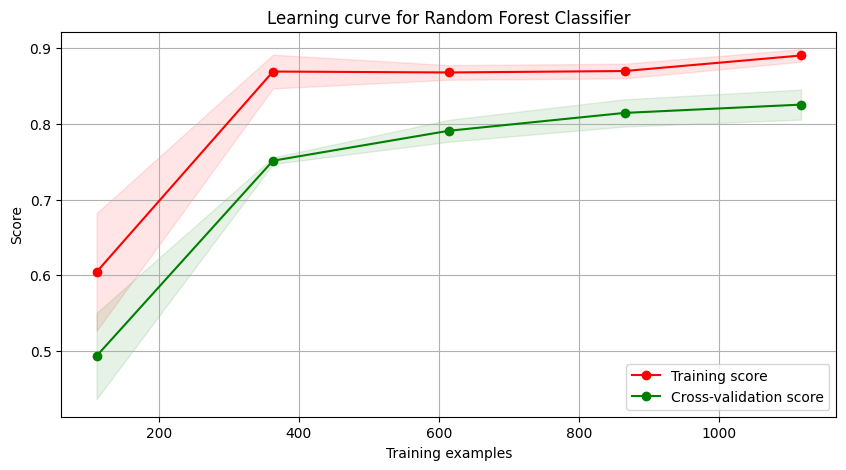

In [107]:
modelRF = clf_rf.best_estimator_
plot_learning_curve(modelRF, X_train, y_train, "Learning curve for Random Forest Classifier")
print("RF Model score on train data:", modelRF.score(X_train, y_train))

In [108]:
modelRF.fit(X_train, y_train)
# Predictions
predictions = modelRF.predict(X_test)
# Evaluate the model
accuracyRF = balanced_accuracy_score(y_test, predictions)
print(f"Accuracy of the RF model on Test Data: {accuracyRF * 100:.2f}%")

Accuracy of the RF model on Test Data: 80.99%


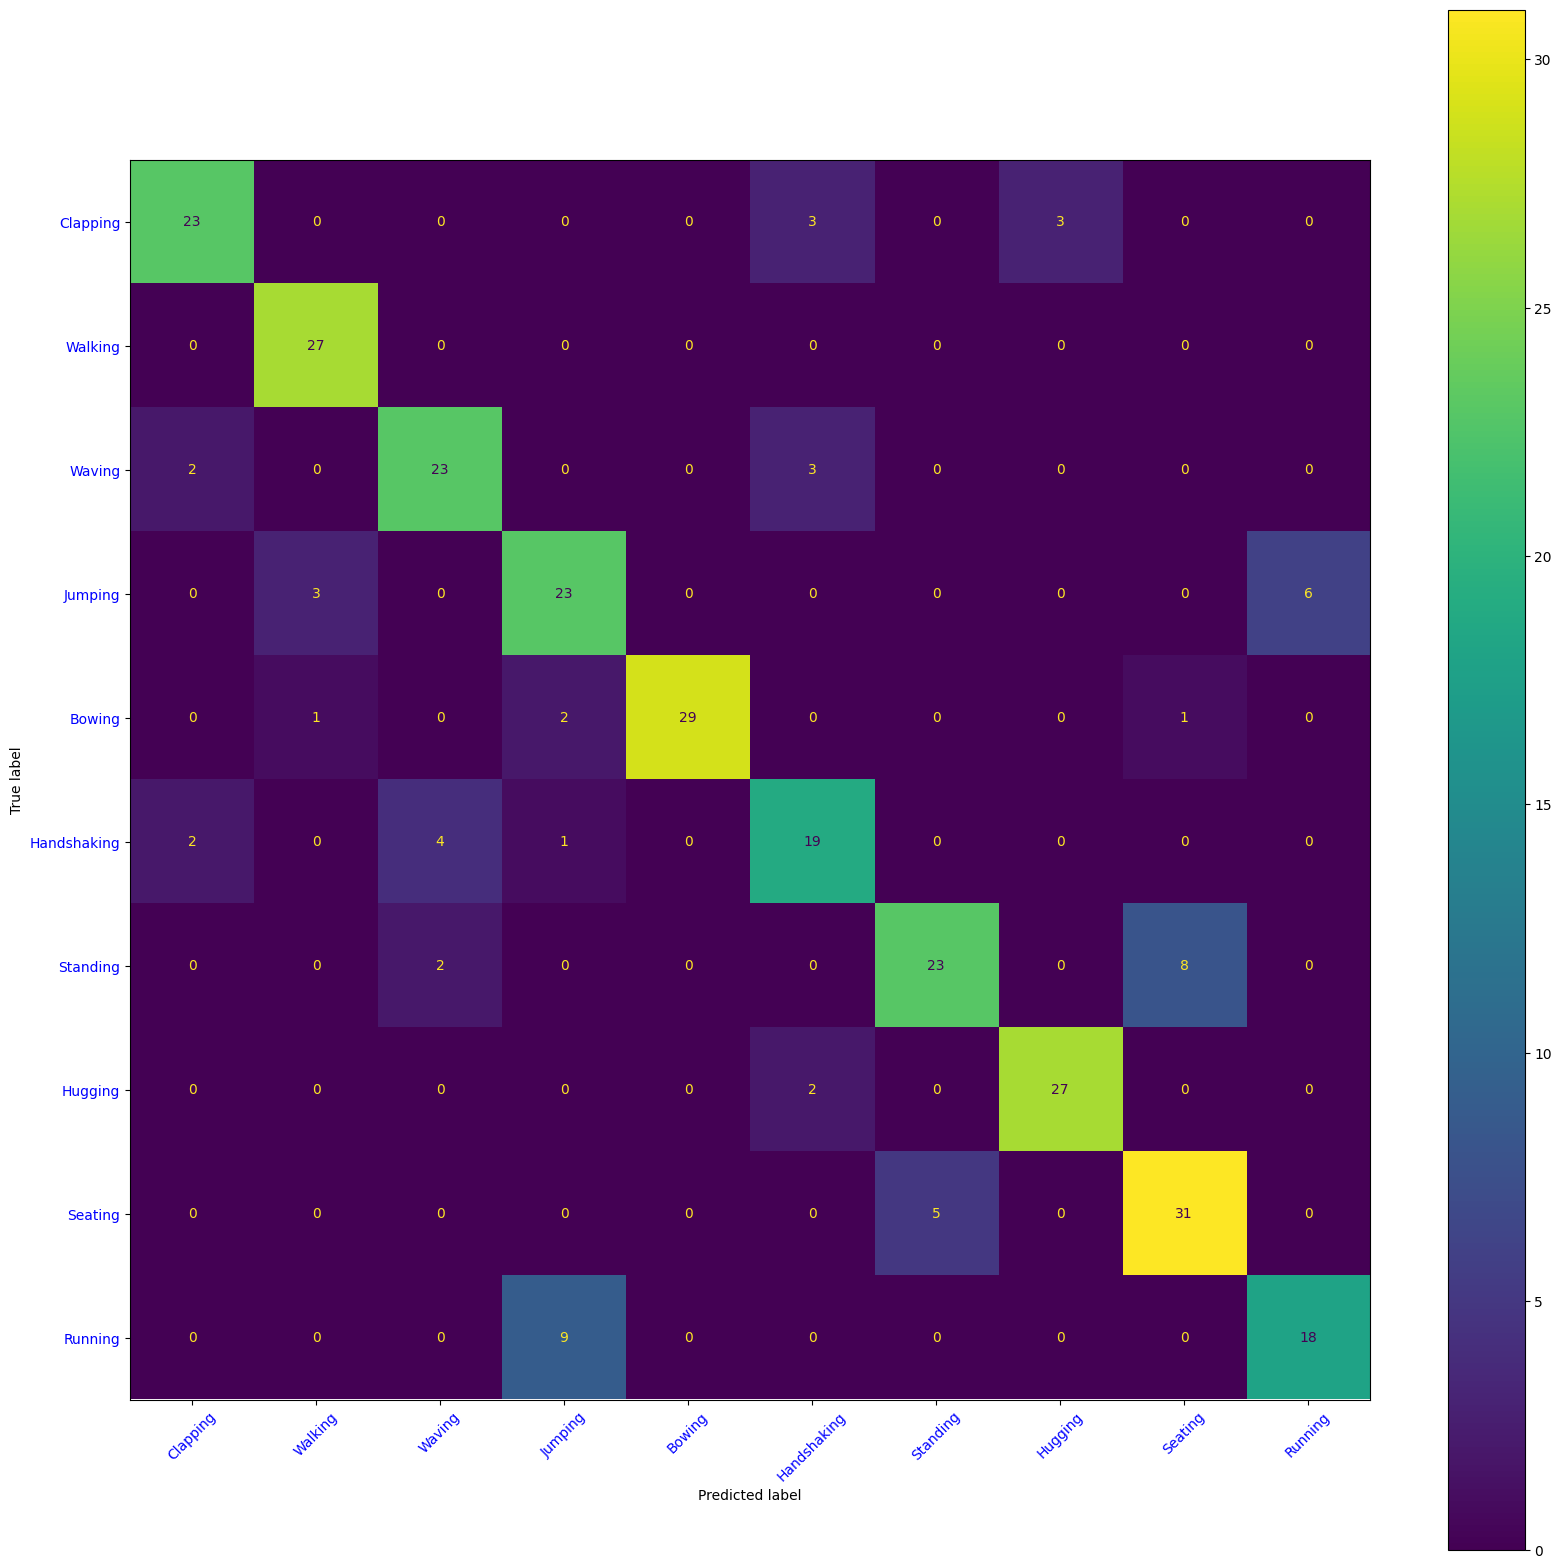

In [109]:
generateConfusionMatrix(y_test, predictions)

### Support Vector Machine (SVM) Model

Similarly, we opted to opt for Support Vector Machines (SVMs) as an alternative model due to the following reasons:

1. **High Dimensionality Handling:** EMG data is inherently high-dimensional, with multiple channels (electrodes) capturing the electrical activity of muscles. SVMs are well-suited for high-dimensional spaces, making them an excellent choice for our dataset.

2. **Effectiveness in Small Datasets:** Although our dataset is substantial, SVMs are known for their effectiveness even in scenarios where the number of samples is relatively small compared to the number of features. This characteristic ensures robust model performance.

3. **Kernel Trick:** One of the most powerful features of SVMs is their ability to utilize the kernel trick. This allows the model to operate in a transformed feature space without explicitly computing the coordinates of the data in that space. For our EMG data, this means we can efficiently handle non-linear relationships between features.

4. **Margin Maximization:** SVMs focus on maximizing the margin between classes, which can lead to better generalization on unseen data. This property is particularly beneficial for EMG data, where the distinction between different physical actions might be subtle.

5. **Robustness to Overfitting:** Given the right regularization parameters, SVMs can be very robust against overfitting, especially in high-dimensional spaces. This is crucial for ensuring that our model performs well not just on the training data but also on new, unseen EMG signals.

6. **Versatility:** The ability to choose different kernels (linear, polynomial, radial basis function, etc.) provides the flexibility to experiment with various approaches to find the best fit for our data's characteristics.

In summary, the choice of SVM as a first step in our analysis was motivated by its compatibility with the high-dimensional, complex nature of EMG data and its robustness in model training and generalization. This makes it a strong candidate for establishing a baseline performance that we can compare against more complex models or deep learning approaches in future work.

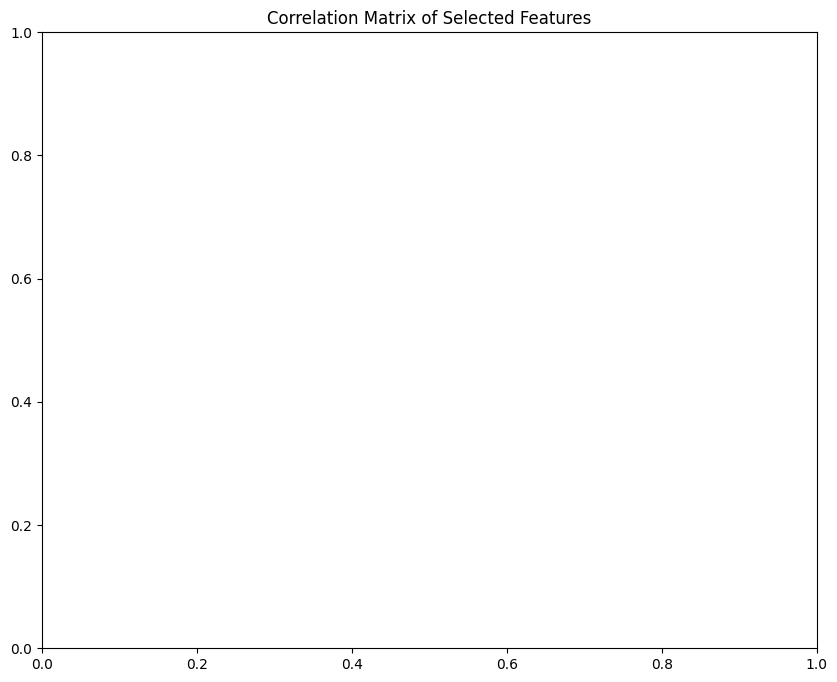

In [110]:
#import seaborn as sns
# Evaluate how the features are correlated
corr_df = X.copy()
# corr_df['Action'] = y_encoded

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Features')
plt.show()

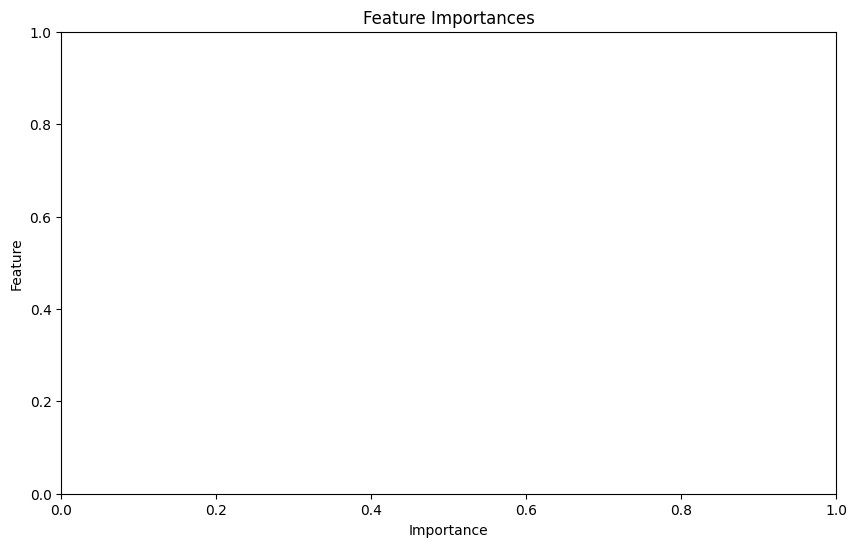

In [111]:
#import seaborn as sns

# Assuming clf_rf is your GridSearchCV object and X_val is your validation dataset

# Step 1: Extract the best estimator
best_rf = clf_rf.best_estimator_

# Step 2: Get feature importances
feature_importances = best_rf.feature_importances_

# Assuming you have a list of feature names
feature_names = X_val.columns

# Step 3: Create a DataFrame mapping features to their importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Step 4: Sort the DataFrame and plot
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
#sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [112]:
# Determine a threshold for selection
# Option A: Fixed value (e.g., 0.01)
# threshold = 0.26

# Option B: Percentage of the maximum importance (e.g., 10% of the maximum)
threshold = 0.1 * importances_df['Importance'].max()

# Option C: Based on a quantile (e.g., 75th percentile)
# threshold = importances_df['Importance'].quantile(0.75)

# Option D: Based on the mean importance
# threshold = importances_df['Importance'].mean()

# Option E: Arbitrary selection
# selected_features = importances_df[importances_df['Feature'].isin(['ch1', 'ch3', 'ch5', 'ch7'])]['Feature']

# Filter features based on the threshold
selected_features = importances_df[importances_df['Importance'] >= threshold]['Feature']

# Display the selected features
print("Selected Features:\n", selected_features)

Selected Features:
 2    ch3
5    ch6
1    ch2
0    ch1
6    ch7
3    ch4
7    ch8
4    ch5
Name: Feature, dtype: object


In [113]:
from sklearn.svm import SVC

# Now, X_selected contains only the features with importance above the threshold
print("Shape of X before feature selection:", X.shape)
X_selected = X[selected_features]
print("Shape of X after feature selection:", X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.3, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)


svm_model = SVC(random_state=seed)

# Standardizing the features
X_train_scaled, X_test_scaled, X_val_scaled = normalize_data(X_train, X_test, X_val)
# X_train_scaled, X_test_scaled, X_val_scaled = X_train, X_test, X_val


# Hyperparameter tuning using GridSearchCV
'''param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [1, 0.1, 0.01],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Specifies the kernel type
}
'''
'''
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'kernel': ['rbf'],  # Specifies the kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}
'''
param_grid = {
    'C': np.logspace(-4,3,5),  # Regularization parameter
    'gamma': np.logspace(-4,3,5),  # Kernel coefficient
    'kernel': ['rbf']  # Specifies the kernel type
}


svm = SVC(random_state=seed)
clf_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = verb)

clf_svm.fit(X_train_scaled, y_train)

# Dipalying the grid search results in a dataframe - only the mean test score is displayed
results = pd.DataFrame(clf_svm.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)
param_columns = [col for col in results.columns if col.startswith('param_')]

display(results[param_columns])
print("Best parameters:", clf_svm.best_params_)
print("Best score:", clf_svm.best_score_)
print("Best estimator:", clf_svm.best_estimator_)

Shape of X before feature selection: (1997, 8)
Shape of X after feature selection: (1997, 8)


,param_C,param_gamma,param_kernel
13,1000.0,auto,rbf
12,1000.0,scale,rbf
11,100.0,auto,rbf
10,100.0,scale,rbf
9,10.0,auto,rbf


Best parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.8410906298003071
Best estimator: SVC(C=1000, random_state=42)


[0.93454044 0.93845355 0.94327741 0.94175722 0.93882305]
[0.00107063 0.005245   0.00409396 0.00327125 0.00223299]
[0.69184444 0.78774491 0.80701914 0.82883452 0.84141785]
[0.01287149 0.02476753 0.01657608 0.02821439 0.02241682]
SVM Model score on train data: 0.9377236936292055


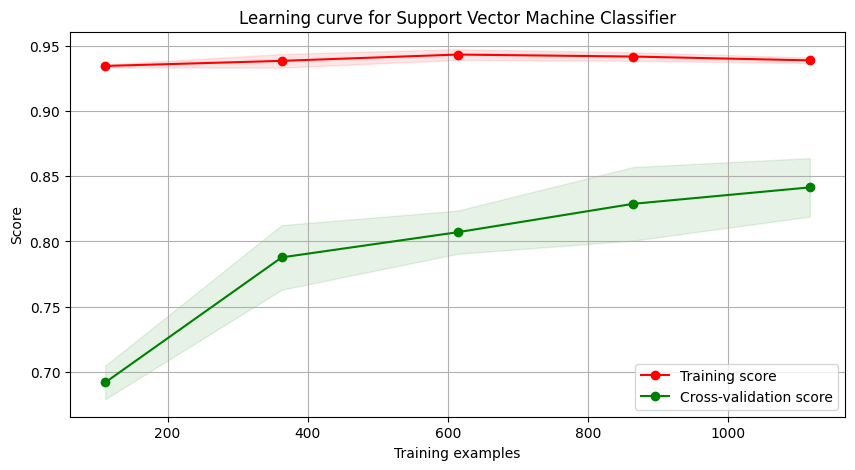

In [114]:
modelSVM = clf_svm.best_estimator_
modelSVM.fit(X_train_scaled, y_train)
plot_learning_curve(modelSVM, X_train_scaled, y_train, "Learning curve for Support Vector Machine Classifier")
print("SVM Model score on train data:", modelSVM.score(X_train_scaled, y_train))

In [115]:
# Predictions
predictions = modelSVM.predict(X_test_scaled)
# Evaluate the model
accuracySVM = balanced_accuracy_score(y_test, predictions)
print(f"Accuracy of the SVM model on Test Data: {accuracySVM * 100:.2f}%")

Accuracy of the SVM model on Test Data: 82.18%


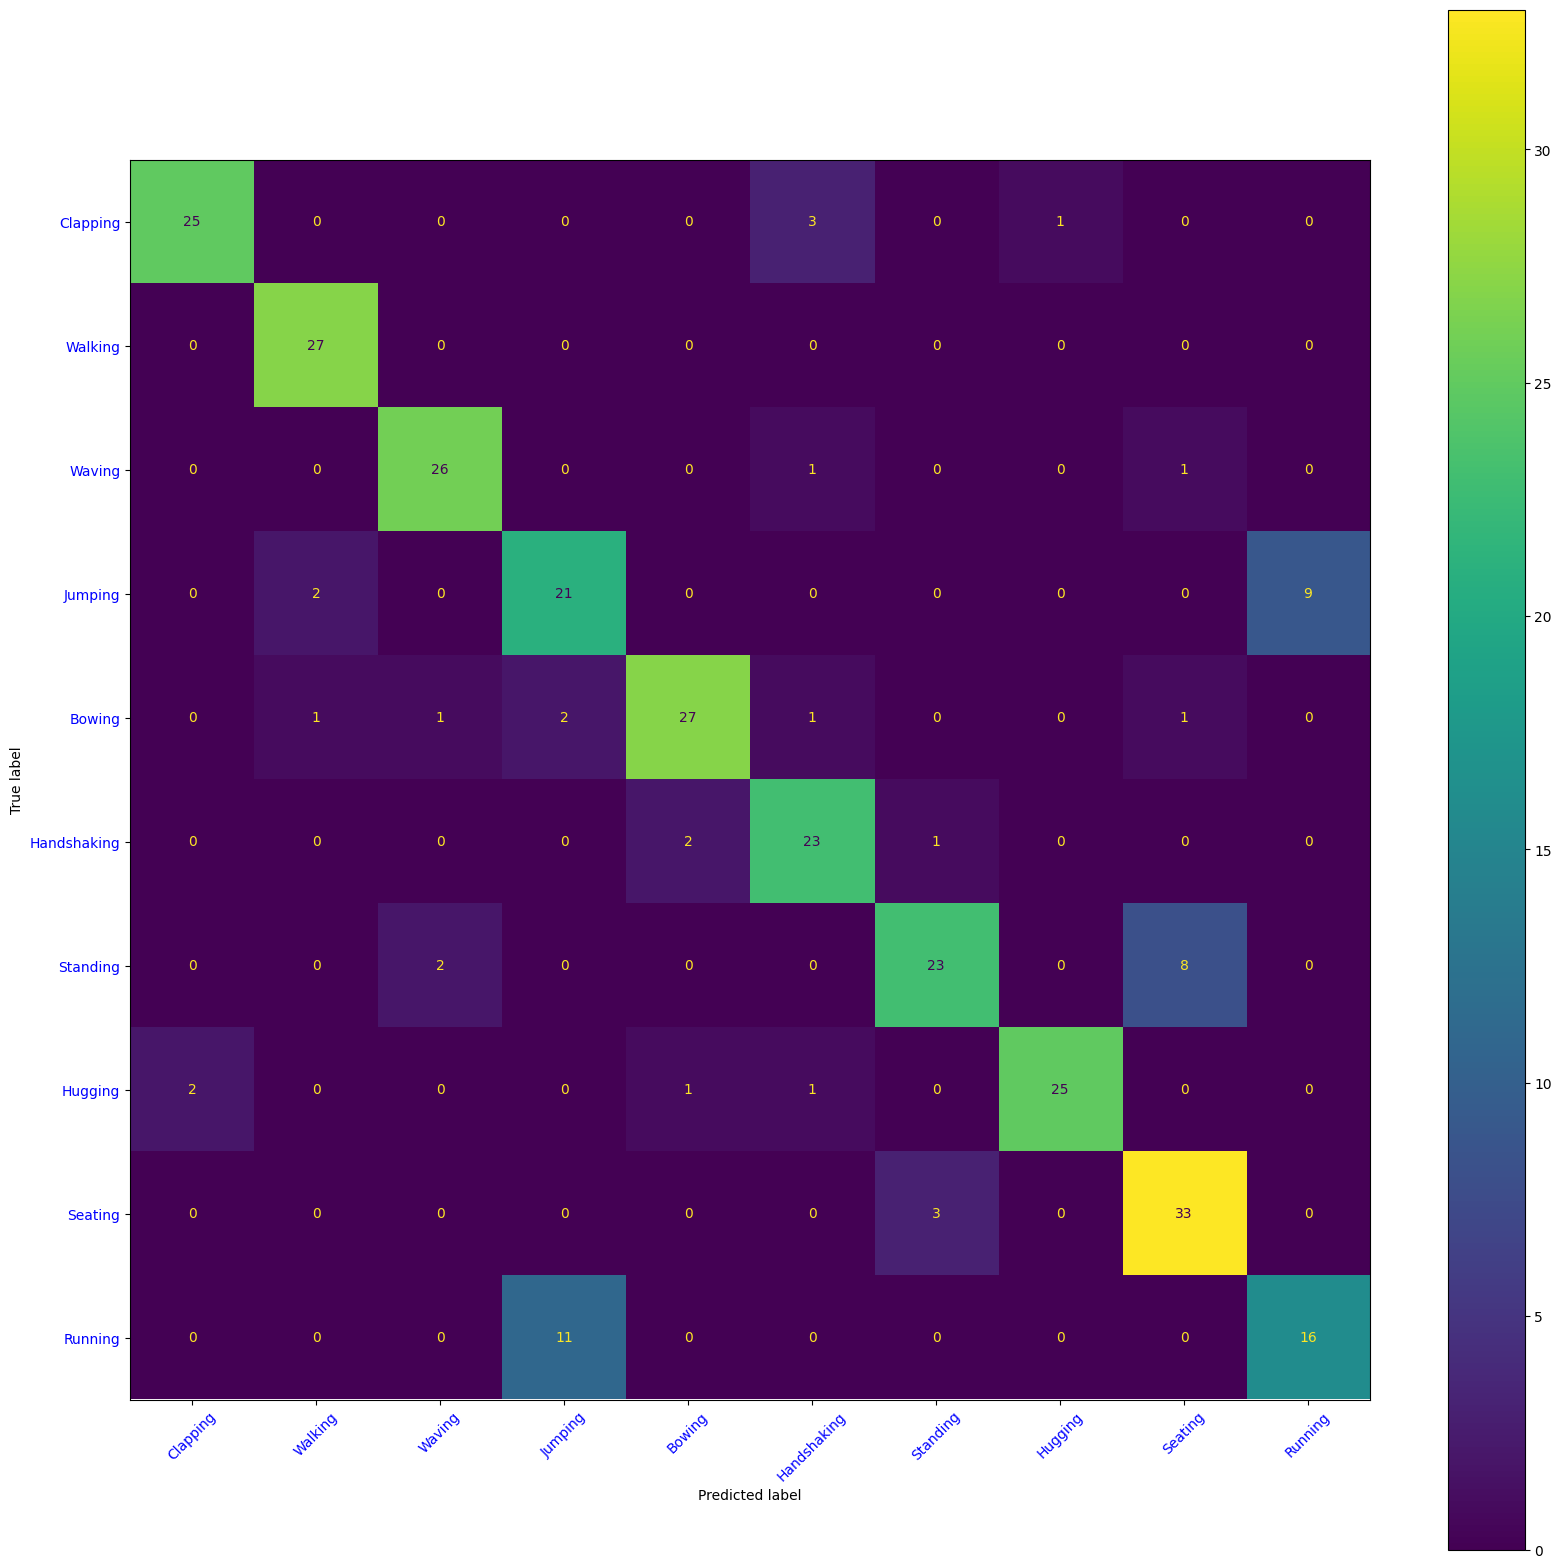

In [116]:
generateConfusionMatrix(y_test, predictions)

## Conclusion
This notebook presented an analysis of EMG data using Random Forest and SVM models. The choice of models was based on their suitability for the dataset's characteristics. Further analysis could explore more complex models or deep learning approaches for potentially improved accuracy.

Future work may include the application of Convolutional Neural Networks (CNNs) to leverage spatial correlations in the data for potentially superior classification performance.

In [117]:
plt.show()